In [14]:
from glob import glob
from tqdm import tqdm
from time import time
import logging
import os
import argparse
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
import matplotlib.pyplot as plt

from model import Unet
from dataset import ImageDataset

import torch
from model import Unet

BATCH_SIZE = 1
EPOCHS = 100
LR = 0.0001

checkpoints_path = '/home/workspace/iot_ai_model/check_points/unet'
data_path = '/home/workspace/iot_ai_model/dataset/supervisely_person'

paths = glob(os.path.join(data_path,"**/*.png"))

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [49]:
def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('true', '1'):
        return True
    elif v.lower() in ('false', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
        
def dice_loss(inputs, targets, smooth=1):
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  

    return 1-dice 

def display_image(img, mask, local = False):
    img = img[0].cpu().numpy()
    mask = mask[0].cpu().numpy()
    
    img = np.transpose(img, (1,2,0))
    mask = np.transpose(mask, (1,2,0))
    
    img = img * 255
    img = np.minimum(np.maximum(img, 0), 255)
    mask[mask > 0.5] = 255
    mask[mask <= 0.5] = 0
    
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.int16)
    green = np.zeros_like(mask)
    green[:,:,1] = mask[:,:,1]
#     img[green >= 255] = img[green >= 255] * 3
#     img[img >= 255] = 255

#     other = np.zeros_like(mask)
#     other[:,:,[0,2]] = mask[:,:,[0,2]] 
#     img[other >= 255] = img[other >= 255] * 0.3
    
    plt.imshow(img)
    # cv2.imshow('img', img)
    # cv2.waitKey(1)

In [10]:
dataset = ImageDataset(data_path, augmentation=False, preload=False)
loader = torch.utils.data.DataLoader(dataset, batch_size= BATCH_SIZE, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet().to(device)
model.load_state_dict(torch.load('/home/workspace/iot_ai_model/check_points/unet/model_state_dict_latest.pt'))
model = model.eval()

In [ ]:
cost= 0.
for filepath, img, mask in loader:
    mask = mask.to(device).type(torch.float32)
    img = img.to(device).type(torch.float32)
    output = model(img)
    loss = dice_loss(output, mask)
    cost += loss.cpu().item()
    print(filepath, loss)

print(cost / len(dataset))

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet().to(device)
model.load_state_dict(torch.load('/home/workspace/iot_ai_model/check_points/unet/model_state_dict_latest.pt'))
model = model.eval()

In [12]:
img = img.to(device).type(torch.float32)
with torch.no_grad():
    output = model(img)

In [37]:
dice_loss(output, mask)

tensor(0.0156, device='cuda:0')

In [20]:
import numpy as np
import cv2

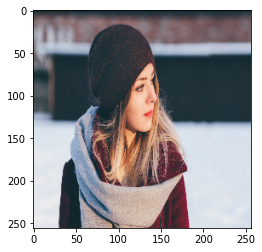

In [50]:
display_image(img, output)

In [42]:
output.shape

torch.Size([1, 3, 256, 256])

In [43]:
mask = mask.to(device).type(torch.float32)

In [44]:
mask.shape

torch.Size([1, 3, 256, 256])

tensor(0.9153, device='cuda:0', grad_fn=<RsubBackward1>)

In [25]:
filepath

('/home/workspace/iot_ai_model/dataset/supervisely_person/images/ds10_pexels-photo-687782.png',)

In [8]:
def inference(model_path, data_path, display = False):
    logger.info('model loading.. {}'.format(model_path))
    batch_size = 1
     # os.path.join("..","models","main.trt")
    logger.info('dataset loading..')
   
    # with open(data_path, 'r') as f:
    #     line = f.readlines()

    
    logger.info('start inferencing')
    preds = []
    targets = []
    cnt = 0
    
    base_dir = os.path.dirname(data_path)
    imgs = []
    masks = []
    filepaths = []
    
    # checkpoints_path = 'check_points/unet'
    model_path = f"{checkpoints_path}/model_state_dict_latest.pt"
    output = f'{checkpoints_path}/model.onnx'
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Unet().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    dataset = ImageDataset(data_path, augmentation=False)
    loader = torch.utils.data.DataLoader(dataset, batch_size= BATCH_SIZE, shuffle=False)
    
    total = len(dataset)
    logger.info('number of test dataset : {}'.format(total))
    
    start_time = time()
    pre_elap = 0.0
    fps = 0.0
    cost = .0
    loss = .0
    for idx, (filename, img, mask) in enumerate(loader):
        img = img.to(device).type(torch.float32)
        mask = mask.to(device).type(torch.float32)
        filename = filename[0]
        output = model(img)
        loss = dice_loss(img, output)
        
        cost += loss
        
        logger.info('{}/{} - {},  fps: {:.1f}, dice loss: {:.1f}'.format(idx+1, total, filename, fps, (1-loss)))

        if(display):
            display_image(img, output)
        
        elap = time() - start_time
        fps = max(0.0, 1.0 / (elap - pre_elap))
        pre_elap = elap
        
    if(display):
        cv2.destroyAllWindows()

    # preds = torch.tensor(preds)
    # targets = torch.tensor(targets)
    # # acc = (correct/len(dataset))
    # f1_score = f1(preds, targets) 
    
    elap = time() - start_time
    fps = total / elap
    logger.info('dice coefficient: {:.4f}, fps: {:.4f}'.format(cost/total, fps))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet().to(device)
model.load_state_dict(torch.load('/home/workspace/iot_ai_model/check_points/unet/model_state_dict_latest.pt'))
model.eval()

In [4]:
params_cnt = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
params_cnt

5685495

In [ ]:
inference('e', data_path)